In [1]:
%matplotlib inline


from __future__ import division

import numpy as np
import scipy
import time, re, os, sys
import copy as cp

import matplotlib.pyplot as plt
import seaborn
from scipy.stats import multivariate_normal
import scipy.spatial.distance as dst
seaborn.set_context("paper",font_scale=2)
seaborn.set_style("whitegrid")


kernel = lambda x1,x2: k*np.exp((-.5)*((x1-x2)**2)/l**2)

In [2]:
def get_sqdists(x,y=None):
    
    if type(y)!=np.ndarray:
        if x.ndim==1:
            dists = dst.pdist(np.vstack([x,np.zeros(x.shape)]).T,metric='sqeuclidean')
        else:
            dists = dst.pdist(x)
            
        dists = dst.squareform(dists)
        
    else:
        if x.ndim==1:
            dists = dst.cdist(np.vstack([x,np.zeros(x.shape)]).T,np.vstack([y,np.zeros(y.shape)]).T,metric='sqeuclidean')
        else:
            dists = dst.cdist(x,y)
    return dists

In [3]:
def get_covariance_matrix(x,y=None,k=3,l=.5,add_offset=1e-6,reshape_params=None):
    
        
    distsSq = get_sqdists(x,y)
    
    cov = k*np.exp(-.5*distsSq/(l**2)) 
    
    cov += add_offset
    return cov

# Generate Data

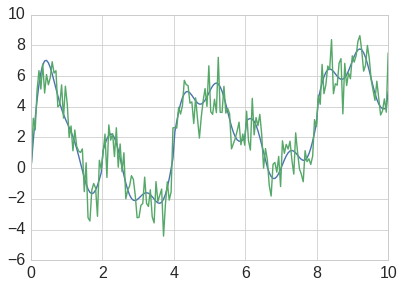

In [4]:
#D = np.array([[3,.1],[4,.1],[5,.1],[40,2],[80,-4]])
xs = np.linspace(0.01,10,num=190)
n_samps = len(xs)
ys = np.sin(.5*np.pi*xs)*3 + np.sin(2*np.pi*xs) + (1/np.exp(xs/2))*6*np.sin(1*np.pi*xs) + xs//2
#ys = (1/np.exp(xs/2))*4*np.sin(2*np.pi*xs) + xs/2
#ys = np.hstack([np.zeros(50),np.ones(50)*2]) - 1
plt.plot(xs,ys)

D = np.vstack([xs,ys+np.random.normal(scale=1,size=xs.shape)]).T

plt.plot(xs,D[:,1])

n_samps = 220
x_samples = np.linspace(0,10,num=n_samps)

In [5]:
#define parameters for the GP regression
k = 2e0
l = 1e-1

In [6]:
K = get_covariance_matrix(D[:,0],k=k,l=l,add_offset=0)#np.zeros([D.shape[0],D.shape[0]])
K += 2*np.eye(D.shape[0])   #add the noise term

#this is K* is common notation. Covariance between unseen and seen data points
Kst = get_covariance_matrix(x=x_samples,y=D[:,0],k=k,l=l,add_offset=0)  

#This is K** covariance matrix just between unseen and unseen x-values
Kstst = get_covariance_matrix(x=x_samples,k=k,l=l,add_offset=0)


## Specify Prior and Infer Posterior Distribution

In [7]:
Kstst.shape

(220, 220)

In [8]:
np.zeros(n_samps).shape

(220,)

In [9]:
GP_prior = multivariate_normal(np.zeros(n_samps),cov=Kstst + np.eye(n_samps)*1e-6)

In [10]:
GP_mean = Kst.dot(np.linalg.inv(K)).dot(D[:,1])

In [11]:
GP_cov = (Kstst - Kst.dot(np.linalg.inv(K)).dot(Kst.T)) + np.eye(GP_mean.shape[0])*1e-6

In [12]:

GP_posterior = multivariate_normal(GP_mean,GP_cov)

#  This is success enjoy the beautiful plot of samples from the posterior

(0, 6.3)

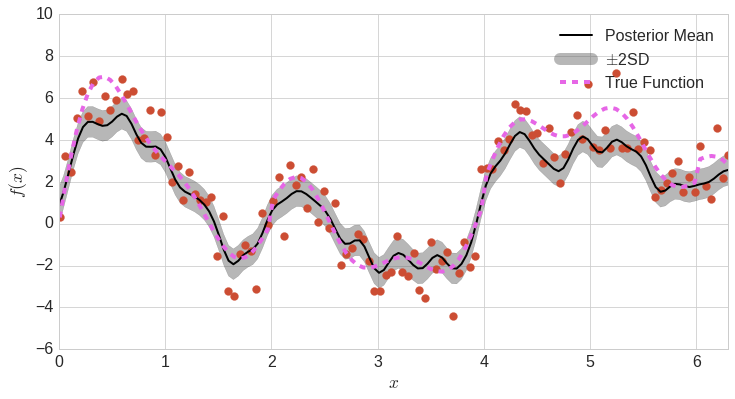

In [13]:
plt.figure(figsize=(12,6))

ax = plt.gca()

#for i in range(4):
#    ax.plot(x_samples,GP_posterior.rvs())
    
#ax.plot(x_samples,GP_posterior.rvs(),label='Posterior Samples')


ax.plot(x_samples,GP_mean,linewidth=2,color='k',label='Posterior Mean')



ax.fill_between(x_samples, GP_mean-np.sqrt(np.diag(GP_cov)), GP_mean+np.sqrt(np.diag(GP_cov)), facecolor=[.3]*3,alpha=.4, interpolate=True)
ax.plot([0], [0], color=[.3]*3,alpha=.4,linewidth=12, label='$\pm$2SD')


ax.plot(D[:,0],ys,color=[.9,.4,.9],linestyle='--',linewidth=4,label='True Function')
ax.scatter(D[:,0],D[:,1],s=64,color=[.8,.3,.2])

ax.legend(loc='best')
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')
plt.xlim(xmin=0,xmax=6.3)

## Samples From Posterior Distribution of Functions

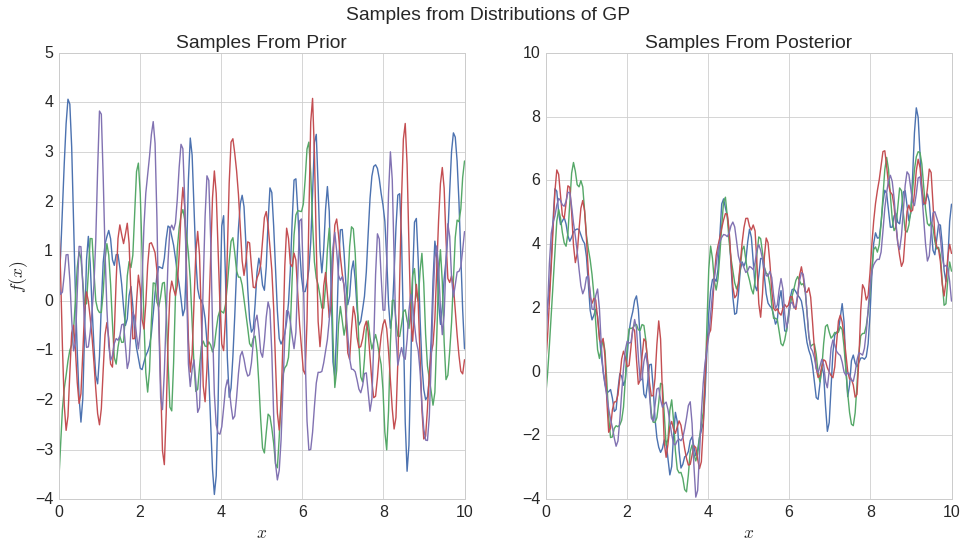

In [14]:
plt.figure(figsize=(16,8))
plt.suptitle('Samples from Distributions of GP \n\n')

plt.subplot(1,2,1)
plt.title('Samples From Prior')
ax = plt.gca()
for i in range(3):
    ax.plot(x_samples,GP_prior.rvs())
    
ax.plot(x_samples,GP_prior.rvs(),label='Samples')
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')


plt.subplot(1,2,2)
ax = plt.gca()
plt.title('\nSamples From Posterior')
for i in range(3):
    ax.plot(x_samples,GP_posterior.rvs())
    
ax.plot(x_samples,GP_posterior.rvs(),label='Samples')
plt.xlabel(r'$x$')




# Repeat Procedure in 2D

In [15]:
n_samps = 80
x_pos = np.linspace(1,5,num=n_samps)
y_pos = np.linspace(3,5,num=n_samps)
xy_pos = np.vstack([x_pos,y_pos])

In [16]:
a,b = np.meshgrid(x_pos,y_pos)

gridspec = a.shape
a = a.flatten()
b = b.flatten()

In [17]:
xy_pos = np.vstack([a.flatten(),b.flatten()])

In [18]:
l = 2.
k = 10

In [19]:
Kstst = get_covariance_matrix(x=xy_pos.T,k=k,l=l,add_offset=0) + np.eye(n_samps**2)*1e-6


In [20]:
sample = np.random.multivariate_normal(mean=np.zeros(Kstst.shape[0]),cov=Kstst)

In [21]:
GP_prior = multivariate_normal(cov=Kstst)

In [22]:
sample = GP_prior.rvs()

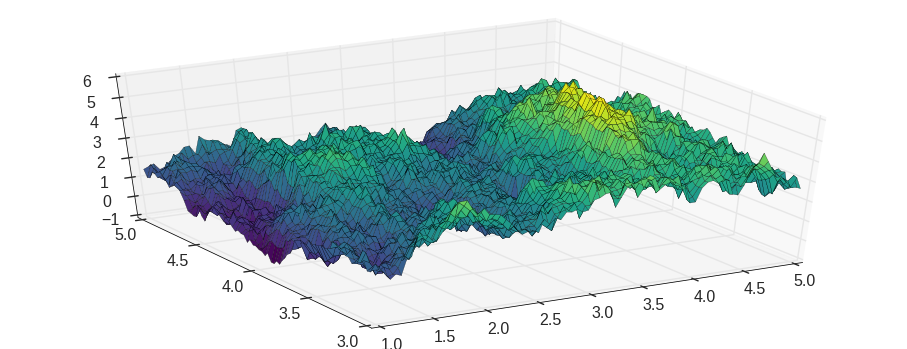

In [23]:
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16,6))
plt.title('Target Surface')
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(a.reshape(gridspec),b.reshape(gridspec),sample.reshape(n_samps,n_samps),rstride=1, cstride=1,cmap=matplotlib.cm.viridis,)
ax.view_init(elev=40,azim=-120)

In [24]:
k = 5

In [25]:
num_sel = 5

In [26]:
K = get_covariance_matrix(x=xy_pos[:,::num_sel].T,k=k,l=l,add_offset=0)

#dummy = np.arange(xy_pos.shape[1])[::4]
#idxs = np.setdiff1d(np.arange(xy_pos.shape[1]),dummy)

K += 2*np.eye(K.shape[0])   #add the noise term

$\mathbf{A}^{-1} = (\mathbf{L}^{-1})^T(\mathbf{L}^{-1}) = (\mathbf{U}^{-1})(\mathbf{U}^{-1})^T $ 

In [27]:
st = time.time()
U = scipy.linalg.inv(scipy.linalg.cholesky(Kstst,lower=False))
new = U.dot(U.T)
print time.time() - st


4.31357192993


In [29]:
st = time.time()
kk = scipy.linalg.inv(Kstst,check_finite=False)
print time.time() - st
#prev 44...

2.77088713646


In [30]:
Kst = get_covariance_matrix(x=.1+xy_pos.T,
                            y=xy_pos[:,::num_sel].T,
                            k=k,l=l,add_offset=0)  

In [31]:
Kstst = get_covariance_matrix(x=.1+xy_pos.T,
                              k=k,l=l,add_offset=0)


In [32]:
GP_mean = Kst.dot(scipy.linalg.inv(K)).dot(sample[::num_sel])


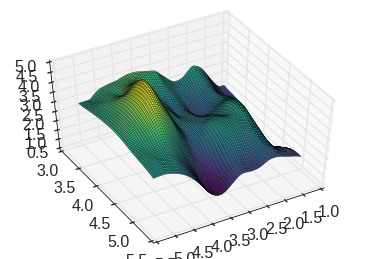

In [33]:
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(a.reshape(gridspec)+.1,b.reshape(gridspec)+.1,GP_mean.reshape(gridspec),
                rstride=1, cstride=1,cmap=matplotlib.cm.viridis,)
ax.view_init(elev=50,azim=60)

 Fraction of data used: 20.0% 
 Total number of datapoints used: 1280.0


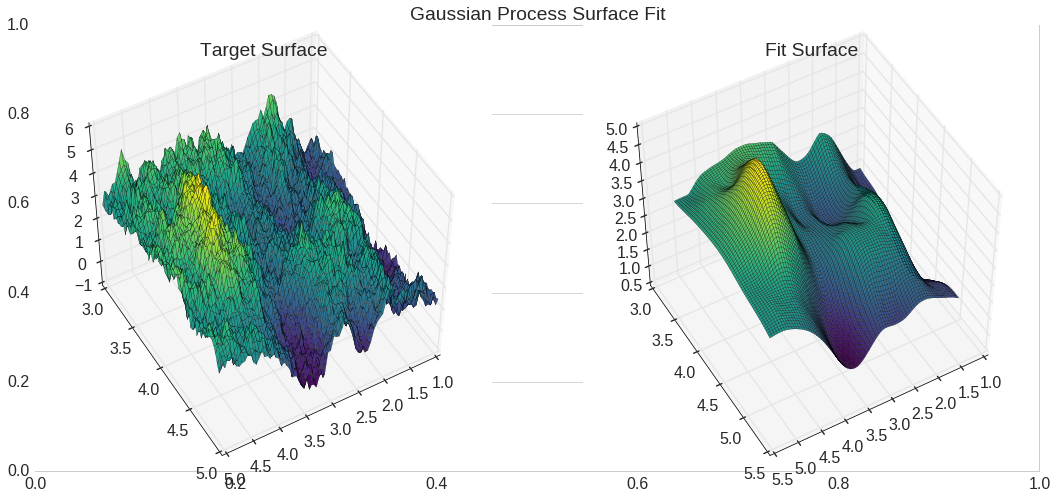

In [34]:
fig = plt.figure(figsize=(18,8))
plt.title('Gaussian Process Surface Fit')

ax = fig.add_subplot(121, projection='3d')
plt.title('Target Surface')

ax.plot_surface(a.reshape(gridspec),b.reshape(gridspec),sample.reshape(n_samps,n_samps),rstride=1, cstride=1,cmap=matplotlib.cm.viridis,)
ax.view_init(elev=50,azim=60)

ax = fig.add_subplot(122, projection='3d')
plt.title('Fit Surface')
ax.plot_surface(a.reshape(gridspec)+.1,b.reshape(gridspec)+.1,GP_mean.reshape(gridspec),
                rstride=1, cstride=1,cmap=matplotlib.cm.viridis)
ax.view_init(elev=50,azim=60)

print ' Fraction of data used: %s%% \n Total number of datapoints used: %s' %(1/num_sel*100,np.round(a.shape[0]*1/num_sel))